# 📓 Notebook 02: Model Training

## Short description of the notebook

# 📚 Dependencies

In [23]:
# Standard library
import os
import sys
import warnings
import random
import logging
import pickle
from pathlib import Path
import re
import joblib

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Others
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from typing import List, Optional, Union
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple
!pip install sktime
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter
from typing import Generator, Tuple
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.pipeline import Pipeline
from dataclasses import dataclass, field


# 🌐 General Setup

In [3]:
%%bash
cd /content

REPO=https://github.com/jacopo-raffaeli/portfolio-replica.git
DIR=portfolio-replica

# Clone if needed, else pull latest
if [ ! -d "$DIR" ]; then
  git clone $REPO > /dev/null 2>&1
else
  cd $DIR
  git pull origin main > /dev/null 2>&1
  cd ..
fi

# Enter project root and install dependencies
cd $DIR
pip install -r requirements.txt > /dev/null 2>&1


In [4]:
# Add repo root to sys.path for imports
PROJECT_ROOT = "/content/portfolio-replica"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    sys.path.append(os.path.join(PROJECT_ROOT, 'src'))

# Set working directory for relative paths
os.chdir(PROJECT_ROOT)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/portfolio-replica


In [5]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 3)

# Seaborn and Matplotlib display options
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Set reproducible seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

# Define paths
data_raw_path = "data/raw/"
data_interim_path = "data/interim/"
data_processed_path = "data/processed/"

# 🛠 Utilities

## Load & Prepare data

In [70]:
def compute_index_returns(
    df_idx: pd.DataFrame,
    index_weights: Dict[str, float] = None
) -> pd.Series:
    """
    Compute weighted composite index returns from raw index price levels.

    Parameters
    ----------
    df_idx : pd.DataFrame
        DataFrame of index price levels (columns are index names).
    index_weights : dict, optional
        Mapping from index column to weight. If None, uses equal weights.

    Returns
    -------
    y : pd.Series
        Composite index returns.
    """
    # Determine which indices to use
    cols = df_idx.columns.tolist()
    if index_weights is None:
        # Equal weights if not provided
        index_weights = {col: 1.0 / len(cols) for col in cols}
    else:
        # Validate provided keys
        missing = set(index_weights) - set(cols)
        if missing:
            raise KeyError(f"Index weights refer to unknown columns: {missing}")

    # Compute simple returns
    ret = df_idx[list(index_weights.keys())].pct_change(fill_method=None).dropna()

    # Apply weights
    weighted = pd.DataFrame({col: ret[col] * weight
                             for col, weight in index_weights.items()},
                            index=ret.index)

    # Sum to get composite
    y = weighted.sum(axis=1)
    y.name = "Target_Index"
    return y

def compute_futures_returns(
    df_fut: pd.DataFrame
) -> pd.DataFrame:
    """
    Compute returns for futures price levels.

    Parameters
    ----------
    df_fut : pd.DataFrame
        DataFrame of futures price levels (columns are futures names).

    Returns
    -------
    X : pd.DataFrame
        Futures returns DataFrame.
    """
    X = df_fut.pct_change(fill_method=None).dropna()
    return X

def align_features_target(
    X: pd.DataFrame,
    y: pd.Series
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Align feature and target on common datetime index.

    Parameters
    ----------
    X : pd.DataFrame
        Feature returns with datetime index.
    y : pd.Series
        Target returns with datetime index.

    Returns
    -------
    X_aligned : pd.DataFrame
    y_aligned : pd.Series
        Subsets of X and y sharing the same index.
    """
    common_idx = X.index.intersection(y.index)
    X_aligned = X.loc[common_idx]
    y_aligned = y.loc[common_idx]
    return X_aligned, y_aligned

def prepare_X_y(
    df_indices: pd.DataFrame,
    df_futures: pd.DataFrame,
    index_weights: Dict[str, float] = None
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    High-level wrapper: compute and align index and futures returns.

    Parameters
    ----------
    df_indices : pd.DataFrame
        Raw index price levels.
    df_futures : pd.DataFrame
        Raw futures price levels.
    index_weights : dict, optional
        Composite index weights. Default: equal weights.

    Returns
    -------
    X, y : aligned returns ready for modeling
    """
    y = compute_index_returns(df_indices, index_weights=index_weights)
    X = compute_futures_returns(df_futures)
    X_aligned, y_aligned = align_features_target(X, y)
    return X_aligned, y_aligned


## Split Data

In [71]:
def generate_backtest_splits(
    y: pd.Series,
    strategy: str = "sliding",
    window_length: int = 52,
    step_length: int = 1
) -> Generator[Tuple[pd.Index, pd.Index], None, None]:
    """
    One-step-ahead backtest splits for replication.

    At each fold:
      - Train on `window_length` points (or all past for expanding)
      - Test on the single point immediately after that window (t+1)

    Parameters
    ----------
    y : pd.Series
        Target series (index only used for length).
    strategy : {'sliding', 'expanding'}
        'sliding'   → fixed-size rolling window of length `window_length`.
        'expanding' → growing window that starts at size `window_length` and then increases.
    window_length : int
        For 'sliding': # samples in each train window.
        For 'expanding': # samples in initial train window.
    step_length : int
        How many periods to move forward between fits.

    Yields
    ------
    train_idx : np.ndarray
        Integer positions for training (length = window_length or growing).
    test_idx : np.ndarray
        Single-element array containing the one-step-ahead index.
    """
    # always one-step ahead
    fh = [1]
    if strategy == "sliding":
        splitter = SlidingWindowSplitter(
            window_length=window_length,
            step_length=step_length,
            fh=fh
        )
    elif strategy == "expanding":
        splitter = ExpandingWindowSplitter(
            initial_window=window_length,
            step_length=step_length,
            fh=fh
        )
    else:
        raise ValueError(f"Unknown strategy '{strategy}'")

    for train_idx, test_idx in splitter.split(y):
        yield train_idx, test_idx


## Simulate Backtest

In [72]:
def prepare_data(X, y, train_idx, test_idx):
    """
    Extract training and test sets for a single backtest iteration.

    Returns:
        X_train, y_train: training features and target
        X_next, y_next: test features and target (next step)
        date_next: date/index of test step
    """
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_next = X.iloc[test_idx].values.flatten()
    y_next = y.iloc[test_idx].iloc[0]
    date_next = y.index[test_idx][0]
    return X_train, y_train, X_next, y_next, date_next

def train_model(build_model, model_params, X_train, y_train):
    """
    Build and fit model pipeline on training data.
    """
    model = build_model(**model_params)
    model.fit(X_train, y_train)
    return model

def unscale_weights(model):
    """
    Extract model weights and unscale them if scaler present.

    Returns:
        original_weights: scaled-back portfolio weights
        scale: scaling factors from scaler or ones
    """
    scaler = model.named_steps.get('scaler', None)
    reg = model.named_steps['regressor']
    normalized_weights = reg.coef_.copy()
    if scaler is not None and hasattr(scaler, 'scale_'):
        scale = scaler.scale_
        original_weights = normalized_weights / scale
    else:
        scale = np.ones_like(normalized_weights)
        original_weights = normalized_weights.copy()
    return original_weights, scale

def compute_step_metrics(X_next, original_weights):
    """
    Compute per-step metrics.
    """
    replica_return = float(np.dot(X_next, original_weights))
    gross_exposure = np.sum(np.abs(original_weights))
    return replica_return, gross_exposure

def simulate_backtest(
    X, y, splitter, build_model, model_params, constraint_funcs=None
):
    """
    Run one-step-ahead replication backtest.

    Returns BacktestResult with weights, returns, metrics, etc.
    """
    # Initialize records
    scale_history = []
    weights_history = []
    gross_exposures = []
    replica_returns_gross = []
    replica_returns_net = []
    target_returns = []
    dates = []

    # Initialize constraints history
    constraints_history = {fn.__name__: [] for fn in constraint_funcs} if constraint_funcs else {}


    for train_idx, test_idx in splitter:
        # Get the proper section of data X, y
        X_train, y_train, X_next, y_next, date_next = prepare_data(X, y, train_idx, test_idx)

        # Train the model
        model = train_model(build_model, model_params, X_train, y_train)

        # Get the scale factor and scaled-back weights to portfolio units
        original_weights, scale = unscale_weights(model)

        # Apply check and constraints
        original_weights = apply_constraints(original_weights, constraint_funcs, weights_history, replica_returns_net, constraints_history)

        # Compute per-step metrics
        replica_return_gross, gross_exposure = compute_step_metrics(X_next, original_weights)

        prev_w = weights_history[-1] if weights_history else None
        transaction_cost = compute_transaction_cost(
            current_weights=original_weights,
            previous_weights=prev_w,
            cost_rate=0.0004
        )

        replica_return_net = replica_return_gross - transaction_cost

        # Record data
        scale_history.append(scale)
        weights_history.append(original_weights)
        gross_exposures.append(gross_exposure)
        replica_returns_gross.append(replica_return_gross)
        replica_returns_net.append(replica_return_net)
        target_returns.append(y_next)
        dates.append(date_next)

    # Transform time-series data
    weights_history = np.vstack(weights_history)
    replica_returns_gross = pd.Series(replica_returns_gross, index=dates, name='replica_returns')
    replica_returns_net = pd.Series(replica_returns_net, index=dates, name='replica_returns')
    target_returns = pd.Series(target_returns, index=dates, name='target_returns')

    # Compute aggregate metrics
    aggregate_metrics = compute_aggregate_metrics(
        target_returns=target_returns,
        replica_returns=replica_returns_net,
        gross_exposures=gross_exposures,
        scaling_factors=scale_history,
        weights_history=weights_history,
        config_params=model_params,
    )

    # Return an experiment summary class
    return BacktestResult(
        model_name=model.__class__.__name__,
        model_params=model_params,
        weights_history=weights_history,
        gross_exposures=gross_exposures,
        scale_history=scale_history,
        replica_returns=replica_returns_net,
        target_returns=target_returns,
        aggregate_metrics=aggregate_metrics,
        constraints_history=constraints_history
    )


In [73]:
@dataclass
class BacktestResult:
    model_name: str
    model_params: dict
    weights_history: np.ndarray
    gross_exposures: list
    scale_history: list
    replica_returns: pd.Series
    target_returns: pd.Series
    aggregate_metrics: dict
    constraints_history: dict

    def summary(self):
        return {
            'model': self.model_name,
            'sharpe': self.aggregate_metrics.get('replica_sharpe'),
            'IR': self.aggregate_metrics.get('information_ratio'),
            'TE': self.aggregate_metrics.get('tracking_error'),
            'corr': self.aggregate_metrics.get('correlation')
        }


## Metrics


In [74]:
def compute_aggregate_metrics(
    target_returns: pd.Series,
    replica_returns: pd.Series,
    gross_exposures: list,
    scaling_factors: list,
    weights_history: list,
    config_params: dict
) -> dict:
    """Compute overall evaluation metrics for backtest."""
    # Compute cumulative returns for both target and replica
    cumulative_target = (1 + target_returns).cumprod()
    cumulative_replica = (1 + replica_returns).cumprod()

    # Annualized return and volatility
    target_mean_return = target_returns.mean() * 52
    replica_mean_return = replica_returns.mean() * 52
    target_vol = target_returns.std() * np.sqrt(52)
    replica_vol = replica_returns.std() * np.sqrt(52)

    # Sharpe ratio
    target_sharpe = target_mean_return / target_vol if target_vol > 0 else np.nan
    replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else np.nan

    # Drawdons
    target_drawdown = 1 - cumulative_target / cumulative_target.cummax()
    replica_drawdown = 1 - cumulative_replica / cumulative_replica.cummax()

    # TE, IR, Corr
    tracking_error = (replica_returns - target_returns).std() * np.sqrt(52)
    information_ratio = (replica_mean_return - target_mean_return) / tracking_error if tracking_error > 0 else np.nan
    correlation = replica_returns.corr(target_returns)

    return {
        **config_params,
        'target_returns': target_returns,
        'replica_returns': replica_returns,
        'cumulative_target': cumulative_target,
        'cumulative_replica': cumulative_replica,
        'target_mean_return': target_mean_return,
        'replica_mean_return': replica_mean_return,
        'target_vol': target_vol,
        'replica_vol': replica_vol,
        'target_sharpe': target_sharpe,
        'replica_sharpe': replica_sharpe,
        'target_max_drawdown': target_drawdown.max(),
        'replica_max_drawdown': replica_drawdown.max(),
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'correlation': correlation,
        'gross_exposures': gross_exposures,
        'avg_gross_exposure': np.mean(gross_exposures),
        'scaling_factors': scaling_factors,
        'weights_history': weights_history
    }


## Run Experiments

In [75]:
def get_model(model_name: str, **params):
    """
    Return a scikit-learn pipeline with a scaler and the selected regression model.

    Parameters
    ----------
    model_name : str
        One of ['linear', 'ridge', 'lasso', 'elasticnet']
    **params : keyword arguments passed to the regressor

    Returns
    -------
    sklearn.pipeline.Pipeline
    """
    regressors = {
        'linear': LinearRegression,
        'ridge': Ridge,
        'lasso': Lasso,
        'elasticnet': ElasticNet
    }

    if model_name not in regressors:
        raise ValueError(f"Model '{model_name}' not supported.")

    regressor = regressors[model_name](**params)

    return Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", regressor)
    ])


In [76]:
def run_single_backtest_experiment(config: dict) -> BacktestResult:
    """
    Run a backtest experiment from a unified configuration dictionary.

    Expected keys in config:
        - model_name: str
        - model_params: dict
        - split_strategy: str
        - window: int
        - step: int
        - constraint_funcs: list or None
    """
    model_name = config['model_name']
    model_params = config['model_params']
    build_model = lambda **p: get_model(model_name, **p)

    splitter = generate_backtest_splits(
        y=config['y'],
        strategy=config.get('split_strategy', 'sliding'),
        window_length=config['window'],
        step_length=config['step']
    )

    return simulate_backtest(
        X=config['X'],
        y=config['y'],
        splitter=splitter,
        build_model=build_model,
        model_params=model_params,
        constraint_funcs=config.get('constraint_funcs', None)
    )


## Display results

In [77]:
import matplotlib.pyplot as plt
import pandas as pd

def display_backtest_result(result):
    """
    Display aggregate metrics and plot cumulative returns for a backtest result.
    """
    print("=== Aggregate Metrics ===")
    for k, v in result.aggregate_metrics.items():
        if isinstance(v, (float, int)):
            print(f"{k}: {v:.4f}")
        elif isinstance(v, str):
            print(f"{k}: {v}")
        # Skip arrays or series here

    cum_target = (1 + result.target_returns).cumprod()
    cum_replica = (1 + result.replica_returns).cumprod()

    plt.figure(figsize=(10, 5))
    plt.plot(cum_target, label="Target Index")
    plt.plot(cum_replica, label="Replica Portfolio")
    plt.title("Cumulative Returns — Backtest Result")
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Constraints

In [89]:
def apply_constraints(original_weights, constraint_funcs, weights_history, replica_returns, constraints_history):
    if constraint_funcs is not None:
        for fn in constraint_funcs:
            original_weights, metadata = fn(original_weights, weights_history, replica_returns)
            constraints_history[fn.__name__].append(metadata)
    return original_weights


In [90]:
def constraint_gross_exposure(weights, weights_history, replica_returns, max_gross=2):
    gross = np.sum(np.abs(weights))
    metadata = {
        'activated': False,
        'violation_amount': 0.0,
        'rescaling_factor': 1.0,
        'gross_exposure': gross
    }
    if gross > max_gross:
        metadata['activated'] = True
        metadata['violation_amount'] = gross - max_gross
        rescale = max_gross / gross
        weights = weights * rescale
        metadata['rescaling_factor'] = rescale
    return weights, metadata


In [91]:
import numpy as np

def calculate_var(returns, method: str, confidence: float = 0.01, horizon: int = 4) -> float:
    """
    Calculate Value at Risk (VaR) over a given time horizon.

    Parameters
    ----------
    returns : array-like
        Historical returns (e.g. weekly P&L series).
    method : {'gaussian', 'historical', 'cornish-fisher'}
        VaR calculation method.
    confidence : float
        Tail probability (e.g. 0.01 for 1% VaR).
    horizon : int
        Time horizon (in same units as returns, e.g. weeks).

    Returns
    -------
    var : float
        Positive number representing the loss at the given confidence/day horizon.
    """
    r = np.asarray(returns)
    if method == 'gaussian':
        mu, sigma = np.mean(r), np.std(r)
        # z for one-sided quantile
        z = abs(np.percentile(np.random.standard_normal(10_000), confidence * 100))
        var = -(mu + z * sigma) * np.sqrt(horizon)
    elif method == 'historical':
        # empirical quantile (these returns are negative if losses)
        hist_q = np.percentile(r, confidence * 100)
        var = -hist_q * np.sqrt(horizon)
    else:
        raise ValueError(f"Unknown VaR method '{method}'")
    return var

def constraint_var_historical(
    weights: np.ndarray,
    weights_history: list,
    replica_returns: list,
    max_var: float = 0.08,
    var_confidence: float = 0.01,
    var_horizon: int = 4,
    lookback: int = 20
) -> tuple[np.ndarray, dict]:
    """
    Project weights to satisfy a maximum historical VaR constraint.

    Parameters
    ----------
    weights : np.ndarray
        Proposed portfolio weights.
    weights_history : list of np.ndarray
        Past weights (unused here).
    replica_returns : list of float
        Past one-step replica returns.
    max_var : float
        Maximum allowed VaR (positive number, e.g. 0.08 for 8%).
    var_confidence : float
        Tail probability for VaR (e.g. 0.01 for 1%).
    var_horizon : int
        Horizon over which to scale VaR (e.g. 4 weeks).
    lookback : int
        Number of past returns to use for historical simulation.

    Returns
    -------
    new_weights, metadata : (np.ndarray, dict)
        Possibly rescaled weights and a metadata dict describing the adjustment.
    """
    metadata = {
        'activated': False,
        'estimated_var': np.nan,
        'violation': 0.0,
        'rescale_factor': 1.0
    }
    if len(replica_returns) < lookback:
        # Not enough history to estimate VaR
        return weights, metadata

    hist = replica_returns[-lookback:]
    est_var = calculate_var(hist, method='historical', confidence=var_confidence, horizon=var_horizon)
    metadata['estimated_var'] = est_var

    if est_var > max_var:
        metadata['activated'] = True
        metadata['violation'] = est_var - max_var
        factor = max_var / est_var
        weights = weights * factor
        metadata['rescale_factor'] = factor

    return weights, metadata


In [92]:
def constraint_turnover_band(
    weights: np.ndarray,
    weights_history: list,
    replica_returns: list,
    min_turnover: float = 0.02,
    max_turnover: float = 0.10
) -> tuple[np.ndarray, dict]:
    """
    Enforce both a minimum no-trade threshold and a maximum turnover cap.

    Parameters
    ----------
    weights : np.ndarray
        Proposed new weights.
    weights_history : list of np.ndarray
        Past weights; last entry is w_{t-1}.
    replica_returns : list
        Past returns (unused here).
    min_turnover : float
        Below this turnover, skip rebalancing entirely (no-trade band).
    max_turnover : float
        Above this turnover, scale changes down to this level.

    Returns
    -------
    new_weights, metadata : (np.ndarray, dict)
    """
    metadata = {
        'activated_min': False,
        'activated_max': False,
        'turnover': 0.0,
        'viol_min': 0.0,
        'viol_max': 0.0,
        'rescale_factor': 1.0
    }
    if not weights_history:
        return weights, metadata

    prev = weights_history[-1]
    turnover = np.sum(np.abs(weights - prev))
    metadata['turnover'] = turnover

    # No-trade band
    if turnover < min_turnover:
        metadata['activated_min'] = True
        metadata['viol_min'] = min_turnover - turnover
        return prev.copy(), metadata  # stay at old weights

    # Max-turnover cap
    if turnover > max_turnover:
        metadata['activated_max'] = True
        metadata['viol_max'] = turnover - max_turnover
        factor = max_turnover / turnover
        weights = prev + factor * (weights - prev)
        metadata['rescale_factor'] = factor

    return weights, metadata


## Transaction costs

In [82]:
def compute_transaction_cost(
    current_weights: np.ndarray,
    previous_weights: Optional[np.ndarray] = None,
    cost_rate: float = 0.0004
) -> float:
    """
    Compute round‑trip transaction cost based on turnover.

    Parameters
    ----------
    current_weights : np.ndarray
        New portfolio weights w_t.
    previous_weights : np.ndarray or None
        Prior portfolio weights w_{t-1}. If None, assumed zero (initial alloc).
    cost_rate : float
        Round‑trip cost per unit turnover (e.g. 0.0004 for 4 bps).

    Returns
    -------
    cost : float
        Transaction cost to be subtracted from portfolio return.
    """
    if previous_weights is None:
        prev = np.zeros_like(current_weights)
    else:
        prev = previous_weights
    turnover = np.sum(np.abs(current_weights - prev))
    return turnover * cost_rate


# 🧩 Prepare Training Data

In [67]:
# Load dataset & retrieve X, y
indices_filepath = data_processed_path + "indices.parquet"
futures_filepath = data_processed_path + "futures_cleaned_imp_LLL1.parquet"
df_indeces = pd.read_parquet(indices_filepath)
df_futures = pd.read_parquet(futures_filepath)

# Set weights for the monster index
index_weights = {
    'HFRXGL': 0.50,
    'LEGATRUU': 0.25,
    'MXWO':   0.25,
    'MXWD':   0.
}

# Extract X, y for model training
X, y = prepare_X_y(df_indeces, df_futures, index_weights)


In [68]:
#TODO: Visualize the monster index and its relations with the futures

# ⚡ Experiments

=== Aggregate Metrics ===
alpha: 0.0100
l1_ratio: 0.0000
target_mean_return: 0.0378
replica_mean_return: 0.0303
target_vol: 0.0555
replica_vol: 0.0480
target_sharpe: 0.6815
replica_sharpe: 0.6309
target_max_drawdown: 0.1339
replica_max_drawdown: 0.0983
tracking_error: 0.0267
information_ratio: -0.2816
correlation: 0.8768
avg_gross_exposure: 1.3739


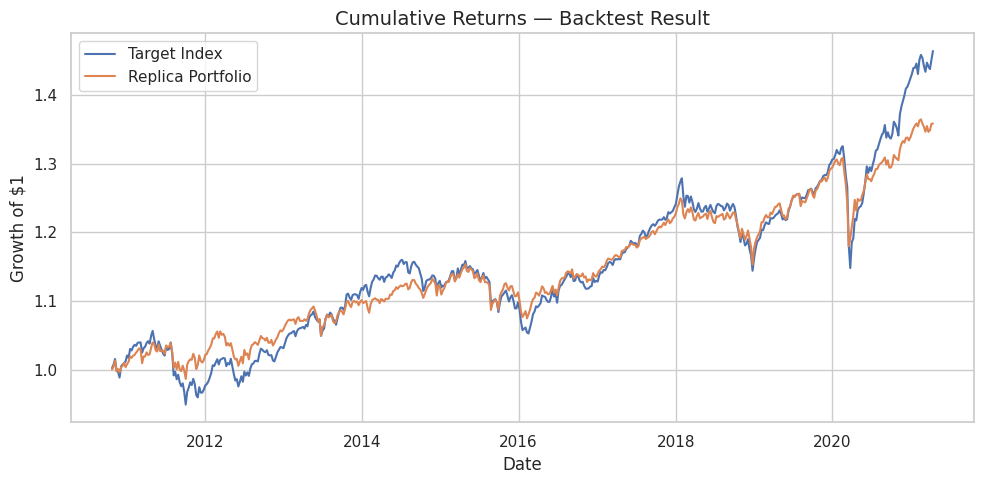

In [96]:
experiment_config = {
    "model_name": "elasticnet",
    "model_params": {"alpha": 0.01, "l1_ratio": 0.},
    "X": X,
    "y": y,
    "split_strategy": "sliding",
    "window": 156,
    "step": 1,
    "constraint_funcs": [
        constraint_gross_exposure,
        constraint_var_historical,
        constraint_turnover_band
    ]
}

result = run_single_backtest_experiment(experiment_config)
display_backtest_result(result)

# 📊 Results

# PUSH

In [ ]:
!git config --global user.email "jacoporaffaeli@gmail.com"
!git config --global user.name "jacopo-raffaeli"

In [ ]:
from getpass import getpass
import os

# 1. Get your GitHub Personal Access Token securely
token = getpass("Paste your GitHub Personal Access Token: ")
os.environ['GITHUB_TOKEN'] = token

# 2. Set your GitHub repo details
GITHUB_USERNAME = "jacopo-raffaeli"
REPO_NAME = "portfolio-replica"
BRANCH = "main"

# 3. Construct remote URL with token embedded (hidden from output)
remote_url = f"https://{token}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git"

# 4. Set git user info (if not done already)
!git config --global user.email "jacoporaffaeli@gmail.com"
!git config --global user.name "jacopo-raffaeli"

# 5. Change remote origin URL to token-embedded one
!git remote set-url origin {remote_url}


Paste your GitHub Personal Access Token: ··········


In [ ]:
# 6. Add and commit changes (customize your commit message)
!git add .
!git commit -m "feat: Add Initial EDA" || echo "No changes to commit."

# 7. Push to GitHub
!git push origin {BRANCH}

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
No changes to commit.
Everything up-to-date


In [ ]:
# Show git status, which files are changed and staged
!git status

# Show last commit files changed (to check if notebook was included)
!git show --name-only --oneline -1

# Show current branch
!git branch

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
f00faf2 (HEAD -> main, origin/main, origin/HEAD) Created using Colab
notebooks/01_Exploratory_Data_Analysis.ipynb
* main
